# Data description & Problem statement: 
The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a Regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables. The data set has 550067 rows and 11 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train the Deep Neural Network model by Keras/Tensorflow
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df=pd.read_csv('train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [3]:
df.drop(['Product_Category_3' ], axis=1, inplace=True)

#Replace missing values with -999
df.fillna(999, inplace=True)

In [4]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in ['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years',
          'Gender', 'Marital_Status', 'Product_Category_1', 'Product_Category_2' ]:
    encode_text_index(df, i)

In [44]:
X=df.drop(['Purchase'], axis=1)
y=df['Purchase']

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

scalor_X=MinMaxScaler().fit(pd.DataFrame(X))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [90]:
# Keras Neural Networks: ___________________
n_input=X.shape[1]

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

model=Sequential()
model.add(Dense(40, activation="relu", input_shape=(n_input, )))
#model.add(Dense(80, activation="relu"))
model.add(Dense(80, activation="relu"))
model.add(Dense(1))


model.compile(optimizer="adam", loss="mean_squared_error")

monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode="auto")
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

history=model.fit(X_train,y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer],  verbose=0)
model.load_weights('best_weights.hdf5') # load weights from best model

model.load_weights('best_weights.hdf5') # load weights from best model
print("Training R^2 score = ", metrics.r2_score(y_train, model.predict(X_train)),"\n")
print("Test R^2 score = ", metrics.r2_score(y_test, model.predict(X_test)) ,"\n")

Training R^2 score =  0.6713085050793836 

Test R^2 score =  0.6645816248192429 



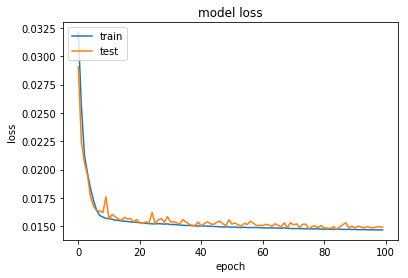

In [91]:
# list all data in history
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

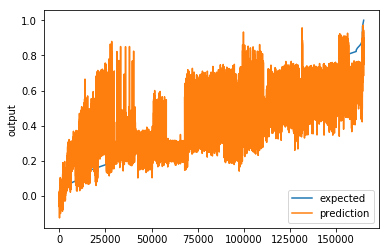

In [92]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=model.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [93]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pred)
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_inv, pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2907.4570036780883


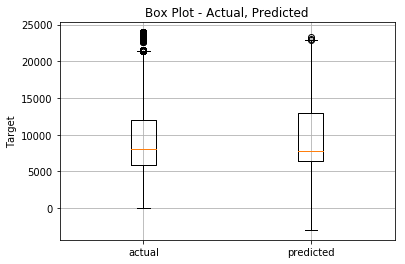

In [94]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

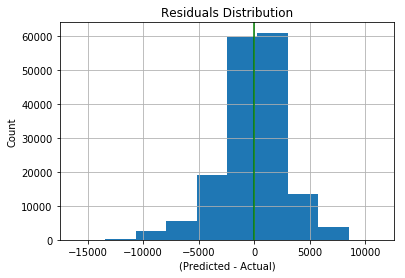

In [95]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()